<a href="https://colab.research.google.com/github/tapilab/text-analytics-tutorial/blob/master/TextAnalyticsTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analytics Tutorial <a class="tocSkip">
**Aron Culotta**  
**Associate Professor of Computer Science**  
**Illinois Institute of Technology**  
*November 13, 2019*
    
https://colab.research.google.com/github/tapilab/text-analytics-tutorial/blob/master/TextAnalyticsTutorial.ipynb

**Goals**
- Provide an introductory overview of text analysis techniques
- Give pointers to tools that may help with your research
- Foster collaboration across disciplines

**Agenda**

- High-level overview of some text analysis problems
- In-depth walk-through of text classication and clustering
  - focus on process, not math
- Open Q&A from audience

## (Very) brief tour of text analysis problems

```
Chicago's Mitch Trubisky is an amazing quarterback!
```

<br><br><br>

1. Classification  
  $\rightarrow$ sports
  
  a. Sentiment analysis  
  $\rightarrow$ positive (or is it negative?)
  
<br><br><br>  

2. Information extraction  
  $\rightarrow$ `{City: Chicago, Person: Mitch Trubisky}`
  
  a. Coreference resolution  
    `{'entity': 'Mitchell Trubisky', 'mentions': ['Mitch', 'Mitch Trubisky', 'Bear's quaterback']}`
  
<br><br><br>

3. Parsing  
  $\rightarrow$  
![tree.png](figs/tree.png)

<br><br><br>

4. Topic modeling  
  $\rightarrow$ `{sports, football, positive emotions, ...}`
  
<br><br><br>

5. Document clustering
  $\rightarrow$ In cluster with documents like:
  ```
  Kansas City's Patrick Mahomes is an great passer!
  I think Russell Wilson is super.
  ```
  
<br><br><br>

6. Text generation  
 $\rightarrow$

  ```
  Chicago's quarterback Mitch Trubisky is wonderful!
  Quarterback Mitch Trubisky of the Chicago Bears is a good player.

  ```
  
<br><br><br>

7. Text regression  
  $\rightarrow$ Trubisky's approval ratings are down 10% this week.




## Classification

Let's walk through a simple classification task:

> Given the text of a movie review, classify it as positive or negative.


### Workflow

1. **Collect** raw data: movie reviews
2. Manually **categorize** them:  positive or negative
3. **Vectorize**: review -> word counts [**features**]
4. **Train** / **Fit**: create classifier
5. **Collect** new raw data
6. **Predict**: compute predictions on new data
7. **Evaluate**: compute accuracy measures



In [37]:
# imports.
import glob

from collections import Counter
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import matplotlib.pyplot as plt
import nltk

import numpy as np

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  average_precision_score, confusion_matrix, classification_report, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import string
import tarfile
import urllib.request
%matplotlib inline
nltk.download('punkt') # for tokenizer


def config_matplotlib():
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)      # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure

    sns.set(style="whitegrid")
    sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
                                 "xtick.labelsize": 14, "ytick.labelsize": 14})
    
def config_pandas():
    pd.set_option('display.width', 2000)
    pd.set_option('max_colwidth', 800)
    
config_matplotlib()
config_pandas()

[nltk_data] Downloading package punkt to /Users/culotta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Collect labeled data

In [38]:
# @title download data
def download_data():
    """ Download and unzip data.
    DONE ALREADY.
    """
    url = 'https://www.dropbox.com/s/8oehplrobcgi9cq/imdb.tgz?dl=1'
    urllib.request.urlretrieve(url, 'imdb.tgz')
    tar = tarfile.open("imdb.tgz")
    tar.extractall()
    tar.close()
download_data()

In [39]:
# @title Inspect data
# data folders
!ls -d data/*/*
# one positive and one negative example:
print('\npositive training example')
!ls data/train/pos/1062_10.txt
!cat data/train/pos/1062_10.txt
print('\n\nnegative training example')
!ls data/train/neg/10277_1.txt
!cat data/train/neg/10277_1.txt

data/test/neg  data/test/pos  data/train/neg data/train/pos

positive training example
data/train/pos/1062_10.txt
I think this show is definitely the greatest show. Jessica Alba does such a great job in it. Michael Weatherly also does an awesome job, as well as the rest of the cast. The show is very intriguing and they have wonderful storylines and their stunts are amazing. It's like watching a 1-hour movie. It's definitely worth watching.

negative training example
data/train/neg/10277_1.txt
I feel totally ripped off. Someone needs to refund the $4.95 I spent at Blockbuster to rent this homemade mess. This is NOT a musical it is a complete waste of time and my evening. What I don't get is why did this get distributed in the first place???...somebody MUST have been doing some heavy drugs the night that deal was made. I've seen better films come out of film schools and I have been to film school so I can say that as a fact. The quality of this work is also just SO VERY bad to view...sho

In [40]:
# @title read all training files 
def read_dir(dir_name):
    data = []
    for label in ['pos', 'neg']:
        for fname in glob.glob(dir_name + '/%s/*txt' % label):
            data.append((fname, label, open(fname).read()))
    return pd.DataFrame(data, columns=['file', 'label', 'text'])

train_df = read_dir('data/train')
print('read %d examples with labels' % len(train_df))
display(train_df.label.value_counts())
train_df

read 400 examples with labels


pos    200
neg    200
Name: label, dtype: int64

,file,label,text
0,data/train/pos/10231_10.txt,pos,"Here's another movie that should be loaded into a satellite, fired into space and pointed in the direction of the galaxy Andromeda to show distant possible civilizations the best of humanity. This movie is so endearingly stupid and revealingly honest in being little more than a rip-off of the already bad movie classic KING KONG from 1976 that it not only manages to upstage that film in terms of sheer belly laugh idiotic goofiness, but successfully predicted much of Peter Jackson's miserable 2005 computer cartoon bearing the same name, as far as a ""romance"" between the giant (here a Yeti) and a gorgeous human female (Antonellina Interlenghi of Umberto Lenzi's CITY OF THE LIVING DEAD, who is very easy on the eyes).<br /><br />The film was made for kids so aside from some innuendo over fi..."
1,data/train/pos/4414_9.txt,pos,"Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional way. I actually watched it while sailing around Cuba on a western Caribbean cruise. It details the life of an 11 year old boy in a small town in Cuba in 1958 and 1959 during the revolution. Not much time is spent on the revolution until the very end, when the Socialist regime came and took the property of the boy's father. The majority of the film is the boy's coming of age and the relationships that arise in a small town where everyone knows everyone else. There are some powerful scenes that everyone can relate to. A class A film with fine acting and directing. This is a film that tells a story with no special effects or grand schemes or real twists. It is a film about people and their liv..."
2,data/train/pos/1111_10.txt,pos,"This is not ""so bad that it is good,"" it is purely good! For those who don't understand why, you have the intellect of a four year old (in response to a certain comment...) Anyways, Killer Tomatoes Eat France is a parody of itself, a parody of you, and a parody of me. It is the single most genius text in cinematic history. I have it and the three prequels sitting on my DVD rack next to Herzog and Kurosawa. It embodies the recognition of absurdity and undermines all that you or me call standard. I write scripts and this movie single-handedly opened up a genre of comedy for me, the likes of which we have never seen. It can only be taken in portions... its sort of exploitive... by now I'm just trying to take up the ten line minimum. My comment ended a while ago. Hopefully it works when I ..."
3,data/train/pos/11900_8.txt,pos,"Both visually and musically stunning. A treat for both the eye and the ear. The quintessential Victorian element of the opening sequences were completely enchanting, helping to create a Christmas scene of which Dickens himself would have been justifiably proud. Technically the production is visually stimulating and the special effects are both imaginatively devised and creatively achieved in a traditional stage setting. The dancing of many of the lead artistes is breathtakingly good. The photography and lighting are first class and the sound recording admirably matches the overall high level of technical skills employed. A great film for all the family at Christmas time and a most delightful discovery which will withstand multiple viewing."
4,data/train/pos/7815_8.txt,pos,'Cry Freedom' is a movie about how far people will go to find the truth.<br /><br />The first half is an interesting portrayal of an unlikely friendship between activist Steve Biko and Editor Don Woods (played fanatically by Dezel Washington and Kevin Klein). While the second half deals with Woods looking for answers on Biko's death.<br /><br />Although most people favor the first half of the movie which focuses on the unlikely friendship between Biko and Woods'. I found the second half about Don woods struggle to have Biko's story be heard around the world much more interesting.
5,data/train/pos/8356_10.txt,pos,"Not sure if this counts as a spoiler

### Preprocessing and feature engineering

All machine learning models require human creativity to determine how each example should be represented. (**feature engineering**)

These decisions can often have a bigger impact on accuracy than which machine learning model you choose.

> why did this half-baked movie get distributed in the first place???...somebody MUST have been doing some heavy drugs. DON'T RENT THIS MOVIE!!!

$\Rightarrow [0,1,2.3,-.2, 0, \ldots , 1.2, 4.5]$

In [5]:
# @title tokenization
"""
string -> list of strings
many decisions:
- punctuation
- contractions
- capitalization
- sentence boundaries
"""

def tokenize(text):    
    # For now, just use NLTK's default tokenizer
    return nltk.tokenize.word_tokenize(text)
    
tokenize("why did this half-baked movie get distributed in the first place???... somebody MUST have been doing some heavy drugs. DON'T RENT THIS MOVIE!!!")

['why',
 'did',
 'this',
 'half-baked',
 'movie',
 'get',
 'distributed',
 'in',
 'the',
 'first',
 'place',
 '?',
 '?',
 '?',
 '...',
 'somebody',
 'MUST',
 'have',
 'been',
 'doing',
 'some',
 'heavy',
 'drugs',
 '.',
 'DO',
 "N'T",
 'RENT',
 'THIS',
 'MOVIE',
 '!',
 '!',
 '!']

In [41]:
train_df['tokens'] = train_df.text.apply(tokenize)
train_df.head()

,file,label,text,tokens
0,data/train/pos/10231_10.txt,pos,"Here's another movie that should be loaded into a satellite, fired into space and pointed in the direction of the galaxy Andromeda to show distant possible civilizations the best of humanity. This movie is so endearingly stupid and revealingly honest in being little more than a rip-off of the already bad movie classic KING KONG from 1976 that it not only manages to upstage that film in terms of sheer belly laugh idiotic goofiness, but successfully predicted much of Peter Jackson's miserable 2005 computer cartoon bearing the same name, as far as a ""romance"" between the giant (here a Yeti) and a gorgeous human female (Antonellina Interlenghi of Umberto Lenzi's CITY OF THE LIVING DEAD, who is very easy on the eyes).<br /><br />The film was made for kids so aside from some innuendo over fi...","[Here, 's, another, movie, that, should, be, loaded, into, a, satellite, ,, fired, into, space, and, pointed, in, the, direction, of, the, galaxy, Andromeda, to, show, distant, possible, civilizations, the, best, of, humanity, ., This, movie, is, so, endearingly, stupid, and, revealingly, honest, in, being, little, more, than, a, rip-off, of, the, already, bad, movie, classic, KING, KONG, from, 1976, that, it, not, only, manages, to, upstage, that, film, in, terms, of, sheer, belly, laugh, idiotic, goofiness, ,, but, successfully, predicted, much, of, Peter, Jackson, 's, miserable, 2005, computer, cartoon, bearing, the, same, name, ,, as, far, as, a, ``, ...]"
1,data/train/pos/4414_9.txt,pos,"Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional way. I actually watched it while sailing around Cuba on a western Caribbean cruise. It details the life of an 11 year old boy in a small town in Cuba in 1958 and 1959 during the revolution. Not much time is spent on the revolution until the very end, when the Socialist regime came and took the property of the boy's father. The majority of the film is the boy's coming of age and the relationships that arise in a small town where everyone knows everyone else. There are some powerful scenes that everyone can relate to. A class A film with fine acting and directing. This is a film that tells a story with no special effects or grand schemes or real twists. It is a film about people and their liv...","[Cuban, Blood, is, one, of, those, sleeper, films, that, has, a, lot, to, say, about, life, in, a, very, traditional, way, ., I, actually, watched, it, while, sailing, around, Cuba, on, a, western, Caribbean, cruise, ., It, details, the, life, of, an, 11, year, old, boy, in, a, small, town, in, Cuba, in, 1958, and, 1959, during, the, revolution, ., Not, much, time, is, spent, on, the, revolution, until, the, very, end, ,, when, the, Socialist, regime, came, and, took, the, property, of, the, boy, 's, father, ., The, majority, of, the, film, is, the, boy, 's, coming, of, age, ...]"
2,data/train/pos/1111_10.txt,pos,"This is not ""so bad that it is good,"" it is purely good! For those who don't understand why, you have the intellect of a four year old (in response to a certain comment...) Anyways, Killer Tomatoes Eat France is a parody of itself, a parody of you, and a parody of me. It is the single most genius text in cinematic history. I have it and the three prequels sitting on my DVD rack next to Herzog and Kurosawa. It embodies the recognition of absurdity and undermines all that you or me call standard. I write scripts and this movie single-handedly opened up a genre of comedy for me, the likes of which we have never seen. It can only be taken in portions... its sort of exploitive... by now I'm just trying to take up the ten line minimum. My comment ended a while ago. Hopefully it works when I ...","[This, is, not, ``, so, bad, that, it, is, good, ,, '', it, is, purely, good, !, For, those, who, do, n't, understand, why, ,, you, have, the, intellect, of, a, four, year, old, (, in, response, to, a, certa

### Feature engineering

Many choices on how to convert tokens into features.

Simple and common: **Bag of words**
- Just store how often each unique term occurs.
- Ignore order

Can also consider:
- **n-grams** (phrases of length $n$)
- lexicons (word lists)
- word embeddings (talk about later)

In [42]:
# @title convert tokens to bags of words
vec = CountVectorizer(tokenizer=None, analyzer=lambda i: i, min_df=1)
X_train = vec.fit_transform(train_df.tokens)
print('feature matrix has %d rows, %d columns, and %d non-zero values (%.5f%% dense)' %
      (X_train.shape[0], X_train.shape[1], X_train.nnz, X_train.nnz / (100*X_train.shape[0] * X_train.shape[1])))

feature matrix has 400 rows, 12991 columns, and 60139 non-zero values (0.00012% dense)


In [43]:
X_train[0].todense()

matrix([[1, 0, 0, ..., 0, 0, 0]])

In [44]:
# term -> column index.
vec.vocabulary_

{'Here': 1827,
 "'s": 86,
 'another': 4383,
 'movie': 9051,
 'that': 11943,
 'should': 11070,
 'be': 4725,
 'loaded': 8581,
 'into': 8174,
 'a': 4046,
 'satellite': 10742,
 ',': 122,
 'fired': 7069,
 'space': 11355,
 'and': 4351,
 'pointed': 9835,
 'in': 7972,
 'the': 11948,
 'direction': 6192,
 'of': 9348,
 'galaxy': 7286,
 'Andromeda': 518,
 'to': 12073,
 'show': 11074,
 'distant': 6267,
 'possible': 9895,
 'civilizations': 5371,
 'best': 4800,
 'humanity': 7841,
 '.': 135,
 'This': 3610,
 'is': 8227,
 'so': 11281,
 'endearingly': 6598,
 'stupid': 11624,
 'revealingly': 10555,
 'honest': 7768,
 'being': 4773,
 'little': 8571,
 'more': 9017,
 'than': 11938,
 'rip-off': 10602,
 'already': 4306,
 'bad': 4665,
 'classic': 5382,
 'KING': 2103,
 'KONG': 2105,
 'from': 7243,
 '1976': 231,
 'it': 8233,
 'not': 9266,
 'only': 9403,
 'manages': 8729,
 'upstage': 12465,
 'film': 7030,
 'terms': 11915,
 'sheer': 11019,
 'belly': 4785,
 'laugh': 8419,
 'idiotic': 7898,
 'goofiness': 7432,
 'but':

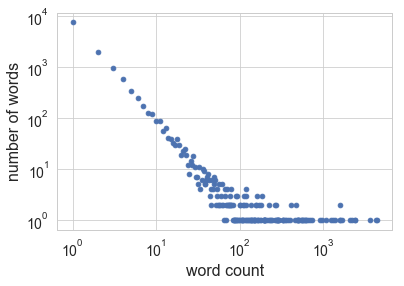

,term,counts
11948,the,4437
122,",",4281
135,.,3665
4351,and,2422
4046,a,2400
9348,of,2219
12073,to,2124
8227,is,1706
154,/,1590
381,>,1587


In [45]:
def plot_top_terms(X, vec):
    count_df = pd.DataFrame(zip(vec.get_feature_names(), X.sum(axis=0).A1),
                            columns=['term', 'counts']).sort_values('counts', ascending=False)
    plt.figure()
    plt.scatter(count_df.counts.value_counts().index.values, count_df.counts.value_counts().values)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('word count')
    plt.ylabel('number of words')
    plt.show()
    display(count_df)
plot_top_terms(X_train, vec)

In [46]:
# @title train classifier
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train, train_df.label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

**Linear Regression**:

$$\hat{y} = \sum_i \beta_i*x_i$$


**Logistic Regression**: Regression with output constrained between 0 and 1
$$ \hat{y} = \frac{1}{1 + \exp (-\sum_i\beta_i x_i)} $$

- $x_i$ is count of term $i$ in an instance
- $\beta_i$ is the real-valued model parameter associated with term $i$
  - E.g., high $\beta_i$ means $i$ is predictive positive class ($y=1$)
- If $\hat{y} > .5$, classify as positive.

In [47]:
# @title Predict on test data
test_df = read_dir('data/test')
test_df['tokens'] = test_df.text.apply(tokenize)
X_test = vec.transform(test_df.tokens)  # why not fit_transform??
print('feature matrix has %d rows, %d columns, and %d non-zero values (%.5f%% dense)' %
      (X_test.shape[0], X_test.shape[1], X_test.nnz, X_test.nnz / (100*X_test.shape[0] * X_test.shape[1])))

test_df['prediction'] = clf.predict(X_test)
test_df.prediction.value_counts()

feature matrix has 400 rows, 12991 columns, and 52354 non-zero values (0.00010% dense)


neg    202
pos    198
Name: prediction, dtype: int64

### Evaluation

- Precision / Recall / F1 / ROC / Confusion Matrix



<table>
    <tr> <td> </td> <td>                   </td>  <td> **truth**  </td>  <td> </td> </tr>
    <tr> <td> </td> <td>                   </td>  <td> **Positive**  </td>  <td> **Negative** </td> </tr>
    <tr> <td> **predicted** </td> <td> **Positive**     </td>  <td> true pos (**tp**)      </td>  <td> false pos (**fp**)   </td> </tr>
    <tr> <td> </td> <td> **Negative** </td>  <td> false neg (**fn**)     </td>  <td> true neg (**tn**)    </td> </tr>
</table>

- **Precision:** $P = \frac{tp}{tp + fp}$,  The fraction of documents classified as positive that are truly positive.


- **Recall:** &nbsp;&nbsp;&nbsp; $R = \frac{tp}{tp + fn}$,  The fraction of truly positive documents that are classified as positive.

- **F1:** harmonic mean of precision and recall: $\frac{2\cdot P \cdot R}{P + R}$ 

In [48]:
print('accuracy=%.3f' % accuracy_score(test_df.label, test_df.prediction))
print(classification_report(test_df.label, test_df.prediction))

accuracy=0.730
              precision    recall  f1-score   support

         neg       0.73      0.73      0.73       200
         pos       0.73      0.72      0.73       200

   micro avg       0.73      0.73      0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400



If we are willing to sacrifice some recall, we can improve precision.

In [49]:
# probability of each class, according to classifier.
proba = clf.predict_proba(X_test)
proba

array([[3.66860712e-02, 9.63313929e-01],
       [7.20923152e-02, 9.27907685e-01],
       [1.65941400e-01, 8.34058600e-01],
       [2.98232133e-01, 7.01767867e-01],
       [5.97861755e-01, 4.02138245e-01],
       [7.56583278e-01, 2.43416722e-01],
       [2.69581682e-02, 9.73041832e-01],
       [7.91511643e-01, 2.08488357e-01],
       [7.78323641e-03, 9.92216764e-01],
       [1.67104353e-02, 9.83289565e-01],
       [2.83382333e-01, 7.16617667e-01],
       [1.12381699e-01, 8.87618301e-01],
       [9.84153182e-01, 1.58468185e-02],
       [4.01979844e-01, 5.98020156e-01],
       [5.40431029e-02, 9.45956897e-01],
       [7.34630847e-01, 2.65369153e-01],
       [3.57664229e-01, 6.42335771e-01],
       [6.42743980e-02, 9.35725602e-01],
       [7.65575410e-01, 2.34424590e-01],
       [3.67511179e-02, 9.63248882e-01],
       [8.42691729e-01, 1.57308271e-01],
       [1.05281106e-01, 8.94718894e-01],
       [3.97955826e-01, 6.02044174e-01],
       [1.38702501e-04, 9.99861297e-01],
       [3.124858

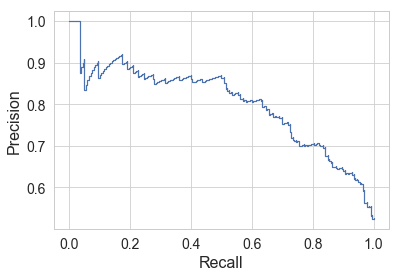

at threshold 0.80, precision=0.86, recall=0.47
avg precision/recall=0.803


In [50]:
# @title precision/recall tradeoff
def precision_recall(test_df, proba):
    precision, recall, thresholds = precision_recall_curve(test_df.label, proba[:,1], pos_label='pos')
    plt.figure()
    plt.step(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    # lowest classification threshold for precision > .85
    threshi = np.where(precision>.85)[0][10]
    print('at threshold %.2f, precision=%.2f, recall=%.2f' % (thresholds[threshi], precision[threshi], recall[threshi]))
    print('avg precision/recall=%.3f' %  average_precision_score(test_df.label, proba[:,1], pos_label='pos'))
    
precision_recall(test_df, proba)

In [51]:
confusion_matrix(test_df.label, test_df.prediction)

array([[147,  53],
       [ 55, 145]])

## Measuring Generalization

The quantity we care about is **generalization error**.
> If I sampled a random document from the future, what is the chance my prediction is wrong?

- As I iteratively improve my classifier, if I look at the test data acuracy, this *taints* my estimate of generalization error.
  - "human" over-fitting
  

### Experimental Design

1. Collect training data
2. Build model
3. Compute cross-validation accuracy on **training data**
4. Tune model
5. Repeat
6. **Report accuracy on new data**

### Cross-validation
 - train on 90%, test on 10%, repeat 10 x's
      - each example appears only once in test set
       
       
<p><a href="https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.svg#/media/File:K-fold_cross_validation_EN.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/1200px-K-fold_cross_validation_EN.svg.png" alt="K-fold cross validation EN.svg"></a><br><font size=-2>By <a href="//commons.wikimedia.org/w/index.php?title=User:Gufosowa&amp;action=edit&amp;redlink=1" class="new" title="User:Gufosowa (page does not exist)">Gufosowa</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=82298768">Link</a></font></p>


In [52]:
def do_cross_validation(clf, X, df, n_folds):
    y = test_df.label.values
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)  # set random seed for reproducible results!
    accuracies = []
    for train_ind, test_ind in cv.split(X):
        clf.fit(X[train_ind], y[train_ind])
        predictions = clf.predict(X[test_ind])
        accuracies.append(accuracy_score(y[test_ind], predictions))
    print('Average 5-fold cross validation accuracy=%.2f (std=%.2f)' %
            (np.mean(accuracies), np.std(accuracies)))

do_cross_validation(clf, X_train, train_df, 5)

Average 5-fold cross validation accuracy=0.62 (std=0.04)


### Tuning

In [53]:

pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=lambda i: i, tokenizer=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=500)),
])
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'clf__C': (0.1, 1, 5),
    # 'clf__max_iter': (10, 50, 80),
}
grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
grid_search.fit(train_df.tokens, train_df.label)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'clf__C': (0.1, 1, 5)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s


Best score: 0.772
Best parameters set:
	clf__C: 1
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.5s finished


In [19]:
grid_search.best_estimator_.fit(train_df.tokens, train_df.label)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function <lambda> at 0x12888c7b8>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=0.5,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
  ...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

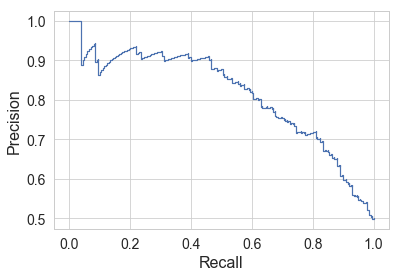

at threshold 0.65, precision=0.88, recall=0.51
avg precision/recall=0.816


In [23]:
clf = grid_search.best_estimator_.named_steps['clf']
vec = grid_search.best_estimator_.named_steps['vect']
X_train = vec.transform(train_df.tokens)
X_test = vec.transform(test_df.tokens)
test_df['prediction'] = clf.predict(X_test)
test_df.prediction.value_counts()
precision_recall(test_df, clf.predict_proba(X_test))

In [24]:
# Get the learned coefficients for the Positive class.
def print_top_cof(clf, vec, n=10):
    coef = clf.coef_[0]
    feats = vec.get_feature_names()
    # Sort them in descending order.
    print('pos features')
    for fi in np.argsort(coef)[::-1][:n]:
        print('%20s\t%.4f' % (feats[fi], coef[fi]))
    print('\nneg features')
    for fi in np.argsort(coef)[:n]:
        print('%20s\t%.4f' % (feats[fi], coef[fi]))
print_top_cof(clf, vec, n=10)

pos features
               great	0.8113
                   i	0.6506
                  It	0.5523
                 his	0.5416
               worth	0.5078
                well	0.4914
                most	0.4862
                very	0.4834
           excellent	0.4438
                best	0.4431

neg features
                   ?	-1.2116
               worst	-0.9336
                 bad	-0.8573
               waste	-0.7237
             nothing	-0.7088
              boring	-0.6950
               looks	-0.5600
               money	-0.5515
            terrible	-0.5214
               could	-0.4986


### Error analysis

- Do I have enough data?
- Am I under- or over-fitting?
- Do the top features make sense? 
- Is the answer encoded in the features?

<img src="https://meditationsonbianddatascience.files.wordpress.com/2017/05/fitgraph.jpg"/>
[source](https://meditationsonbianddatascience.com/2017/05/11/overfitting-underfitting-how-well-does-your-model-fit/)

<img src="https://miro.medium.com/max/1803/1*1ADLHcqXhmtgDBkMF7b2Hw.png">
[source](https://towardsdatascience.com/deep-learning-specialization-by-andrew-ng-21-lessons-learned-15ffaaef627c)

In [33]:
# is the answer encoded in the data??
print(clf.coef_[0][vec.vocabulary_['10/10']])
train_df.text.values[X_train[:,vec.vocabulary_['10/10']].nonzero()[0]][-1]

0.14312976295005064


"I must confess that I was completely shocked by this film. For one, I went to see it on a whim expecting something mediocre, but given this, the most shocking thing was that this was in a populist American cinema at all. This is British comedy at its finest - dark, quirky and funny in ways that American films just never are. I must stop short, however, of recommending this wholeheartedly to anyone; I went to see it with several people, some English, some European and some American and while some of us loved it (mainly from the first two groups), some hated it and found it worthless. If you think you're into this kind of thing then go. If not, don't. 10/10."

In [34]:
# correlation != causation
print(clf.coef_[0][vec.vocabulary_['horror']])
# are all horror movies bad??

-0.23709047601487743


### Increasing complexity

- word counts
- tf-idf transformation: downweight common term ('the', 'a', ...)
  $$tfidf(i, d) = \frac{tf(i, d)}{max_k tf(k, d)} * log(N/df(i))$$
    - $tf(i, d)$: number of times term $i$ appears in document $d$
    - $df(i)$: number of documents that term $i$ appears in
    - $N$: number of documents
- word vectors

![nn](figs/nn.png)
  - Represent each term with a dense vector (~300 values)
  - Word vectors become hidden nodes in a neural network.
  - An additional hidden layer allows non-linear transformations of word vectors
  - Training the model to optimize $p(w_i \mid v_{i-1} \ldots v_{i-n})$ results in "useful" vectors for $v$.
  
![vis1.jpg](figs/vis1.jpg)

![vis2.jpg](figs/vis2.png)

![vis3.jpg](figs/vis3.png)

- Fancier deep learning models
  - LSTM: accounts for word order
  
<img src="https://i0.wp.com/blog.exxactcorp.com/wp-content/uploads/2018/12/sentiment-classification.png?resize=605%2C444&ssl=1"/>
[source](https://www.kdnuggets.com/2019/02/deep-learning-nlp-rnn-cnn.html)

### Scalability

- We normally wouldn't read all the text into memory at once
  - Instead, stream from disk and store only the sparse feature matrix
  
```python
X = vec.fit_transform(read_lines_from_disk(file_name))
```

## Additional reading
- BERT word vectors: https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb
- BERT classification https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb
- Debugging with google's WhatIf tool: https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_Toxicity_Text_Model_Comparison.ipynb#scrollTo=UwiWGrLlSWGh
- Keras tutorial https://keras.rstudio.com/articles/tutorial_basic_text_classification.html